In [1]:
import seaborn as sns
import visualization as vs
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
from scipy import stats
from functools import reduce
from seaborn.utils import ci

In [62]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

# H-MFN

In [3]:
# wp_final = pd.read_csv("final/wp-150/wp-H-MFN.csv")
# bk_final = pd.read_csv("final/bk-150/bk-H-MFN.csv")
# gw_final = pd.read_csv("final/gws-150/gws-H-MFN.csv")

wp_final = pd.read_csv("final/wp-150/wp-H-2-10-CP-MFN.csv")
bk_final = pd.read_csv("final/bk-150/bk-H-2-10-CP-MFN.csv")
gw_final = pd.read_csv("final/gws-150/gws-H-2-10-CP-MFN.csv")

wp_final['dataset'] = "Weeplace"
bk_final['dataset'] = "BrightKite"
gw_final['dataset'] =  "Gowalla"

In [4]:
def transform_df(df_H_MFN):
    df_H_MFN = df_H_MFN[['Included Rank','userid_y', 'CCE_alters', 'CCE_ego_alters', 'Pi_alters', 'Pi_ego_alters', 
                                     'LZ_entropy', 'Pi', 'n_meetupers_x', 'n_meetupers_y', 'userid_x', 'dataset']]
    df_H_MFN = df_H_MFN.rename({'Included Rank': 'Included', 
                                'userid_x': 'userid',
                                'Pi': 'Pi_ego'}, axis=1)
    df_H_MFN['Pi_alters_ratio'] = df_H_MFN['Pi_alters'] / df_H_MFN['Pi_ego'] 
    df_H_MFN['Pi_ego_alters_ratio'] = df_H_MFN['Pi_ego_alters'] / df_H_MFN['Pi_ego'] 
    return df_H_MFN

In [5]:
df_final = transform_df(pd.concat([wp_final, bk_final, gw_final]))

In [6]:
df_used = df_final[(df_final['Included'] <=10) & (df_final['n_meetupers_x']>=10)]

In [7]:
lower = df_used.groupby(['Included', 
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper = df_used.groupby(['Included', 
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid = df_used.groupby(['Included', 'dataset'])['Pi_alters_ratio'].mean().reset_index()

In [8]:
final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'dataset']), [mid, lower, upper])
final.columns = ['included', 'dataset', 'mean', 'lower', 'upper']

In [9]:
final.to_csv('final/150_all_2_10_CP_H_MFN.csv', index=False)

In [29]:
# spearman test

In [36]:
ds_list = df_used['dataset'].unique().tolist()
user_list = df_used['userid'].unique().tolist()

In [38]:
df_used

,Included,userid_y,CCE_alters,CCE_ego_alters,Pi_alters,Pi_ego_alters,LZ_entropy,Pi_ego,n_meetupers_x,n_meetupers_y,userid,dataset,Pi_alters_ratio,Pi_ego_alters_ratio
0,1,moyashi,4.480851,2.819234,0.572350,0.753660,2.981229,0.737002,130,130,26,Weeplace,0.776592,1.022603
1,2,shino-japan,3.896997,2.726172,0.638740,0.763132,2.981229,0.737002,130,130,26,Weeplace,0.866674,1.035455
2,3,kazu-skywalker,3.737099,2.655491,0.656403,0.770278,2.981229,0.737002,130,130,26,Weeplace,0.890640,1.045150
3,4,hirotomo,3.701004,2.606340,0.660360,0.775222,2.981229,0.737002,130,130,26,Weeplace,0.896009,1.051859
4,5,mb6885,3.682320,2.568332,0.662404,0.779032,2.981229,0.737002,130,130,26,Weeplace,0.898783,1.057028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11452,6,6592,6.624965,5.151428,0.254380,0.466523,5.625357,0.402543,20,20,127119,Gowalla,0.631932,1.158941
11453,7,81,6.611641,5.114609,0.256513,0.471363,5.625357,0.402543,20,20,127119,Gowalla,0.637232,1.170963
11454,8,36514,6.598962,5.091129,0.258539,0.474439,5.625357,0.402543,20,20,127119,Gowalla,0.642264,1.178606
11455,9,39697,6.595868,5.085553,0.259032,0.475169,5.625357,0.402543,20,20,127119,Gowalla,0.643489,1.180418


In [53]:
for ds in ds_list:
    count_sm = 0
    count_kd = 0
    df_temp = df_used[df_used['dataset'] == ds]
    ur_ds = df_temp['userid'].unique().tolist()
    for user in ur_ds:
        rank = df_temp[df_temp['userid'] == user]['Included'].tolist()
        Pi_alters_ratio = df_temp[df_temp['userid'] == user]['Pi_alters_ratio'].tolist()
        
        coef_sm, p_sm = spearmanr(rank, Pi_alters_ratio)
        coef_kd, p_kd = kendalltau(rank, Pi_alters_ratio)     
        
        if (coef_sm > 0) & (p_sm < 0.01):
            count_sm +=1
        
        if (coef_kd > 0) & (p_kd < 0.01):
            count_kd +=1

    print(ds, count_sm, count_sm/len(ur_ds), count_kd, count_kd/len(ur_ds),len(ur_ds))

Weeplace 516 0.6834437086092715 526 0.6966887417218544 755
BrightKite 60 0.3468208092485549 58 0.3352601156069364 173
Gowalla 203 0.7837837837837838 204 0.7876447876447876 259


# All these MFNs and TFN (pointplot)

In [10]:
wp_all = pd.read_csv("final/wp-150/wp_shared_all_2_10_CP.csv")
bk_all = pd.read_csv("final/bk-150/bk_shared_all_2_10_CP.csv")
gw_all = pd.read_csv("final/gws-150/gws_shared_all_2_10_CP.csv")
wp_all['dataset'] = "Weeplace"
bk_all['dataset'] = "BrightKite"
gw_all['dataset'] =  "Gowalla"

In [11]:
df_all = pd.concat([wp_all, bk_all, gw_all])

In [12]:
df_all_used = df_all[(df_all['Included'] <=10) & (df_all['n_meetupers_x']>=10)]

In [50]:
df_all_used.groupby(['dataset', 'category', 'userid']).apply(lambda row: spearmanr(row.Included, row.Pi_alters_ratio))

dataset     category   userid          
BrightKite  CB-1D-MFN  0.0                   (0.8060606060606059, 0.004862061101964606)
                       2.0                   (-0.3939393939393939, 0.25999776683488757)
                       3.0                  (-0.8060606060606059, 0.004862061101964606)
                       7.0                  (0.9999999999999999, 6.646897422032013e-64)
                       11.0                (-0.8666666666666665, 0.0011735381801554687)
                                                               ...                     
Weeplace    TFN        yuna-park            (0.7939393939393938, 0.0060999233136969115)
                       yuri-van-geest       (0.8181818181818182, 0.0038149200825507135)
                       zach-linder          (0.9636363636363635, 7.320974809529922e-06)
                       zachariah-schaap      (0.7818181818181817, 0.007547007781067878)
                       zachary-blank        (0.9878787878787878, 9.3074599889555

In [51]:
category = list(set(df_all_used['category'].tolist()))

In [54]:
result = []
for ds in ds_list:
    for cat in category:
        count_sm = 0
        count_kd = 0
        count_mw = 0
        
        df_temp = df_all_used[(df_all_used['dataset'] == ds) & (df_all_used['category'] == cat)]
        ur_ds = df_temp['userid'].unique().tolist()
        for user in ur_ds:
            rank = df_temp[df_temp['userid'] == user]['Included'].tolist()
            Pi_alters_ratio = df_temp[df_temp['userid'] == user]['Pi_alters_ratio'].tolist()

            coef_sm, p_sm = spearmanr(rank, Pi_alters_ratio)
            coef_kd, p_kd = kendalltau(rank, Pi_alters_ratio)  
            mannwhitneyu
            

            if (coef_sm > 0) & (p_sm < 0.01):
                count_sm +=1

            if (coef_kd > 0) & (p_kd < 0.01):
                count_kd +=1

        print(ds, cat, count_sm, count_sm/len(ur_ds), count_kd, count_kd/len(ur_ds),len(ur_ds))
        result.append([ds, cat, count_sm, count_sm/len(ur_ds), count_kd, count_kd/len(ur_ds),len(ur_ds)])

Weeplace SW-24H-MFN 262 0.9065743944636678 261 0.903114186851211 289
Weeplace CB-1D-MFN 251 0.8685121107266436 250 0.8650519031141869 289
Weeplace CB-1H-MFN 218 0.754325259515571 223 0.7716262975778547 289
Weeplace TFN 200 0.6920415224913494 206 0.71280276816609 289
BrightKite SW-24H-MFN 34 0.5151515151515151 32 0.48484848484848486 66
BrightKite CB-1D-MFN 35 0.5303030303030303 34 0.5151515151515151 66
BrightKite CB-1H-MFN 29 0.4393939393939394 29 0.4393939393939394 66
BrightKite TFN 32 0.48484848484848486 33 0.5 66
Gowalla SW-24H-MFN 140 0.9655172413793104 140 0.9655172413793104 145
Gowalla CB-1D-MFN 139 0.9586206896551724 140 0.9655172413793104 145
Gowalla CB-1H-MFN 113 0.7793103448275862 116 0.8 145
Gowalla TFN 114 0.7862068965517242 117 0.8068965517241379 145


In [56]:
pd.DataFrame(result)

,0,1,2,3,4,5,6
0,Weeplace,SW-24H-MFN,262,0.906574,261,0.903114,289
1,Weeplace,CB-1D-MFN,251,0.868512,250,0.865052,289
2,Weeplace,CB-1H-MFN,218,0.754325,223,0.771626,289
3,Weeplace,TFN,200,0.692042,206,0.712803,289
4,BrightKite,SW-24H-MFN,34,0.515152,32,0.484848,66
5,BrightKite,CB-1D-MFN,35,0.530303,34,0.515152,66
6,BrightKite,CB-1H-MFN,29,0.439394,29,0.439394,66
7,BrightKite,TFN,32,0.484848,33,0.500000,66
8,Gowalla,SW-24H-MFN,140,0.965517,140,0.965517,145
9,Gowalla,CB-1D-MFN,139,0.958621,140,0.965517,145


In [59]:
category

['SW-24H-MFN', 'CB-1D-MFN', 'CB-1H-MFN', 'TFN']

In [65]:
final = []
for ds in ds_list:
    df_temp = df_all_used[df_all_used['dataset'] == ds]

    df_SW = df_temp[df_temp['category'] == category[0]]['Pi_alters_ratio']
    df_1D = df_temp[df_temp['category'] == category[1]]['Pi_alters_ratio']
    df_1H = df_temp[df_temp['category'] == category[2]]['Pi_alters_ratio']
    df_T = df_temp[df_temp['category'] == category[3]]['Pi_alters_ratio']

                               
    stats_S_D, p_S_D = wilcoxon(df_SW, df_1D)
    stats_S_H, p_S_H = wilcoxon(df_SW, df_1H)
    stats_S_T, p_S_T = wilcoxon(df_SW, df_T)
    
    stats_D_H, p_D_H = wilcoxon(df_1D, df_1H)
    stats_D_T, p_D_T = wilcoxon(df_1D, df_T)
    
    stats_H_T, p_H_T = wilcoxon(df_1H, df_T)

#     stats_S_D, p_S_D =  mannwhitneyu(df_SW, df_1D)
#     stats_S_H, p_S_H =  mannwhitneyu(df_SW, df_1H)
#     stats_S_T, p_S_T =  mannwhitneyu(df_SW, df_T)
    
#     stats_D_H, p_D_H = mannwhitneyu(df_1D, df_1H)
#     stats_D_T, p_D_T = mannwhitneyu(df_1D, df_T)
    
#     stats_H_T, p_H_T = mannwhitneyu(df_1H, df_T)
    
   

    df_stats = pd.DataFrame([[stats_S_D, p_S_D ], 
                             [stats_S_H, p_S_H],
                             [stats_S_T, p_S_T], 
                             [stats_D_H, p_D_H],
                            [stats_D_T, p_D_T], 
                             [stats_H_T, p_H_T]
                            ])
    df_stats['dataset'] = ds
    final.append(df_stats)
final = pd.concat(final)

In [66]:
final

,0,1,dataset
0,780790.0,8.027565e-04,Weeplace
1,654561.0,4.178669e-187,Weeplace
2,737540.0,4.361357e-165,Weeplace
3,626505.0,2.013899e-192,Weeplace
4,726029.0,1.270496e-165,Weeplace
5,1604933.0,1.299756e-01,Weeplace
0,9628.0,8.707609e-17,BrightKite
1,20320.0,6.788675e-46,BrightKite
2,18966.0,2.435761e-61,BrightKite
3,25467.0,1.279541e-33,BrightKite


In [57]:
# CI computation

In [14]:
lower = df_all_used.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper = df_all_used.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid = df_all_used.groupby(['Included', 'category',
                           'dataset'])['Pi_alters_ratio'].mean().reset_index()

In [15]:
all_final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [mid, lower, upper])
all_final.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']

In [16]:
all_final.to_csv('final/150_all_category_CP.csv', index=False)

# All these MFNs and TFN (Global Jaccard Similarity)

In [17]:
import pickle
import matplotlib.pyplot as plt

In [18]:
pickle_in = open("final/wp-150/wp_VIP_similarity_CP.pickle", "rb")
wp_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("final/bk-150/bk_VIP_similarity_CP.pickle", "rb")
bk_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("final/gws-150/gws_VIP_similarity_CP.pickle", "rb")
gws_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

In [19]:
df = [bk_vip_similarity, gws_vip_similarity, wp_vip_similarity]

In [20]:
datasets = ['BrightKite', 'Gowalla', 'Weeplace']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':


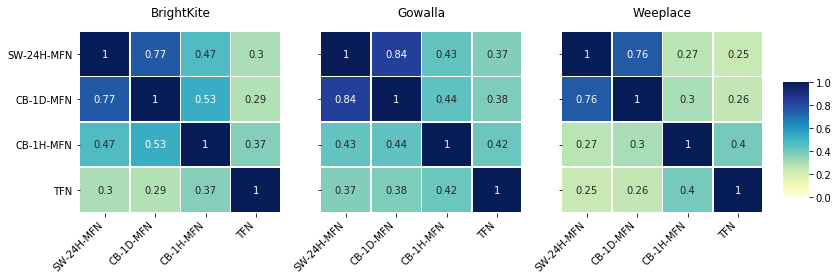

In [21]:
fig, axn = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(df[i] , cmap="YlGnBu", ax=ax, linewidths=.5, annot=True,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)
    ax.xaxis.set_label_position('bottom')
    ax.set_title(datasets[i], pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('fig/VIP_similarity_CP.pdf')

# VIP LR

In [22]:
wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_CP.csv')
wp_vip_LR['dataset'] = 'Weeplace'

bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_CP.csv')
bk_vip_LR['dataset'] = 'BrightKite'

gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_CP.csv')
gw_vip_LR['dataset'] = 'Gowalla'

In [23]:
vip_LR = pd.concat([wp_vip_LR, bk_vip_LR, gw_vip_LR])

In [24]:
vip_LR

,Included,userid,userid_y,category,USLR,SLR,dataset
0,1,4sq-seoul,jaehoon-choi,CB-1H-MFN,0.025862,0.236620,Weeplace
1,2,4sq-seoul,dylan-ko,CB-1H-MFN,0.068966,0.087324,Weeplace
2,3,4sq-seoul,jihoon-yeo,CB-1H-MFN,0.068966,0.290141,Weeplace
3,4,4sq-seoul,leeclo,CB-1H-MFN,0.077586,0.281690,Weeplace
4,5,4sq-seoul,sunghwan-kim,CB-1H-MFN,0.189655,0.354930,Weeplace
...,...,...,...,...,...,...,...
5795,6,10971,25028,TFN,0.021061,0.018851,Gowalla
5796,7,10971,25024,TFN,0.005055,0.005977,Gowalla
5797,8,10971,25046,TFN,0.014322,0.008736,Gowalla
5798,9,10971,24408,TFN,0.010110,0.005977,Gowalla


In [25]:
vip_lower = vip_LR.groupby(['Included', 'category',
                         'dataset'])['USLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_LR.groupby(['Included', 'category',
                         'dataset'])['USLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_LR.groupby(['Included', 'category', 'dataset'])['USLR'].mean().reset_index()
vip_USLR = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_USLR.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']
vip_USLR['LR'] = 'USLR'

In [26]:
vip_lower = vip_LR.groupby(['Included', 'category',
                         'dataset'])['SLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_LR.groupby(['Included', 'category',
                         'dataset'])['SLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_LR.groupby(['Included', 'category', 'dataset'])['SLR'].mean().reset_index()

vip_SLR = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_SLR.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']
vip_SLR['LR'] = 'SLR'

In [27]:
vip_LR_final = pd.concat([vip_USLR, vip_SLR])

In [28]:
vip_LR_final.to_csv('final/150_all_LR_CP.csv', index=False)

# H-MFN vs TFN Cross validation

In [99]:
wp_vip_cv =  pd.read_csv('final/wp-150-cv/wp_join_vip10_CV.csv')
wp_vip_cv['dataset'] = 'Weeplace'

bk_vip_cv = pd.read_csv('final/bk-150-cv/bk_join_vip10_CV.csv')
bk_vip_cv['dataset'] = 'BrightKite'

gw_vip_cv = pd.read_csv('final/gws-150-cv/gws_join_vip10_CV.csv')
gw_vip_cv['dataset'] = 'Gowalla'

In [100]:
vip_CV = pd.concat([wp_vip_cv, bk_vip_cv, gw_vip_cv])

In [101]:
vip_CV 

,Included,alters_names,CCE_alters,CCE_ego_alters,Pi_alters,Pi_ego_alters,Pi_alters_ratio,Pi_ego_alters_ratio,userid,category,dataset
0,1,'don-chwojko',8.171960,4.554808,0.036762,0.567411,0.065429,1.009866,suzanne-marlatt,CB-1H-MFN,Weeplace
1,1,'katey-mcgarr',6.124336,4.478870,0.373008,0.576175,0.663872,1.025463,suzanne-marlatt,CB-1H-MFN,Weeplace
2,1,'richlocation',8.007438,4.556638,0.076338,0.567199,0.135865,1.009489,suzanne-marlatt,CB-1H-MFN,Weeplace
3,1,'pamela-vaughter',8.004760,4.544118,0.076913,0.568648,0.136889,1.012067,suzanne-marlatt,CB-1H-MFN,Weeplace
4,1,'kerry-sugrue',7.950789,4.554513,0.088221,0.567446,0.157014,1.009927,suzanne-marlatt,CB-1H-MFN,Weeplace
...,...,...,...,...,...,...,...,...,...,...,...
296665,9,"'10066','10950','10117','54963','25028','25024...",6.839218,6.708959,0.426669,0.439928,1.052095,1.084788,10971,TFN,Gowalla
296666,9,"'10066','10950','10869','54963','25028','25024...",6.766509,6.675511,0.434083,0.443315,1.070376,1.093142,10971,TFN,Gowalla
296667,9,"'10066','10117','10869','54963','25028','25024...",6.825001,6.687089,0.428121,0.442143,1.055676,1.090252,10971,TFN,Gowalla
296668,9,"'10950','10117','10869','54963','25028','25024...",6.886504,6.706455,0.421830,0.440181,1.040163,1.085415,10971,TFN,Gowalla


In [103]:
vip_lower = vip_CV.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_CV.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_CV.groupby(['Included', 'category', 'dataset'])['Pi_alters_ratio'].mean().reset_index()
vip_CV_final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_CV_final.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']

In [105]:
vip_CV_final.to_csv('final/150_all_CV.csv', index=False)